In [4]:
MAKE_BOOK_FIGURES=Trueimport numpy as npimport scipy.stats as stimport matplotlib as mplimport matplotlib.pyplot as plt%matplotlib inlineimport matplotlib_inlinematplotlib_inline.backend_inline.set_matplotlib_formats('svg')import seaborn as snssns.set_context("paper")sns.set_style("ticks")def set_book_style():    plt.style.use('seaborn-v0_8-white')     sns.set_style("ticks")    sns.set_palette("deep")    mpl.rcParams.update({        # Font settings        'font.family': 'serif',  # For academic publishing        'font.size': 8,  # As requested, 10pt font        'axes.labelsize': 8,        'axes.titlesize': 8,        'xtick.labelsize': 7,  # Slightly smaller for better readability        'ytick.labelsize': 7,        'legend.fontsize': 7,                # Line and marker settings for consistency        'axes.linewidth': 0.5,        'grid.linewidth': 0.5,        'lines.linewidth': 1.0,        'lines.markersize': 4,                # Layout to prevent clipped labels        'figure.constrained_layout.use': True,                # Default DPI (will override when saving)        'figure.dpi': 600,        'savefig.dpi': 600,                # Despine - remove top and right spines        'axes.spines.top': False,        'axes.spines.right': False,                # Remove legend frame        'legend.frameon': False,                # Additional trim settings        'figure.autolayout': True,  # Alternative to constrained_layout        'savefig.bbox': 'tight',    # Trim when saving        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off    })def set_notebook_style():    plt.style.use('seaborn-v0_8-white')    sns.set_style("ticks")    sns.set_palette("deep")    mpl.rcParams.update({        # Font settings - using default sizes        'font.family': 'serif',        'axes.labelsize': 10,        'axes.titlesize': 10,        'xtick.labelsize': 9,        'ytick.labelsize': 9,        'legend.fontsize': 9,                # Line and marker settings        'axes.linewidth': 0.5,        'grid.linewidth': 0.5,        'lines.linewidth': 1.0,        'lines.markersize': 4,                # Layout settings        'figure.constrained_layout.use': True,                # Remove only top and right spines        'axes.spines.top': False,        'axes.spines.right': False,                # Remove legend frame        'legend.frameon': False,                # Additional settings        'figure.autolayout': True,        'savefig.bbox': 'tight',        'savefig.pad_inches': 0.1    })def save_for_book(fig, filename, is_vector=True, **kwargs):    """    Save a figure with book-optimized settings.        Parameters:    -----------    fig : matplotlib figure        The figure to save    filename : str        Filename without extension    is_vector : bool        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.    **kwargs : dict        Additional kwargs to pass to savefig    """        # Set appropriate DPI and format based on figure type    if is_vector:        dpi = 1000        ext = '.pdf'    else:        dpi = 600        ext = '.tif'        # Save the figure with book settings    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)def make_full_width_fig():    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)def make_half_width_fig():    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)if MAKE_BOOK_FIGURES:    set_book_style()else:    set_notebook_style()make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

(sampling-categorical)=
# Sampling the categorical

We now show how to sample from a categorical distribution using samples from a uniform distribution.
We start with the Bernoulli distribution, a particular case of the categorical distribution.
Then, we show how to sample from the categorical distribution in general.

## Sampling the Bernoulli distribution
The Bernoulli distribution arises from a binary random variable representing the outcome of an experiment with a given probability of success.
Let us encode success with 1 and failure with 0.
It is a particular case of the Categorical (2 labels).
Then, we say that the random variable

$$
X\sim \operatorname{Bernoulli}(\theta),
$$

is a Bernoulli random variable with parameter $\theta$ if:

$$
X = \begin{cases}
1,\;\text{with probability}\;\theta,\\
0,\;\text{otherwise}.
\end{cases}
$$

To sample from it, we do the following steps:

+ Sample a uniform number $u$ (i.e., a number of $U([0,1])$).

+ If $u\le \theta$, then set $x = 1$.

+ Otherwise, set $x = 0$.

```{admonition} Proof
:class: dropdown

How do we know that this works?
Let us compute the probability of $X=1$.
We start by employing the sum rule:

$$
p(x=1) = \int_0^1 p(x=1|u) p(u) du.
$$

We know that $p(u)=1$.
Also, following the definition of our algorithm, we have that $p(x=1|u)=1$ if $u\le \theta$ and $p(x=1|u)=0$ otherwise.
So, the integral becomes:

$$
p(x=1) = \int_0^\theta 1 du + \int_\theta^1 0 du = \theta.
$$

Well, this is what we wanted.
```

Let's test numerically if this process produces the desired result.
Here is the code:

In [1]:
import numpy as np

def sample_bernoulli(theta : float):
    """Sample from the Bernoulli.
    
    Arguments:
        theta -- The probability of success.
    """
    u = np.random.rand()
    if u <= theta:
        return 1
    return 0

And here is how to use it:

In [2]:
for _ in range(10):
    print(sample_bernoulli(0.5))

1
1
0
1
1
0
1
0
0
0


Let's do a histogram of a huge number of samples:

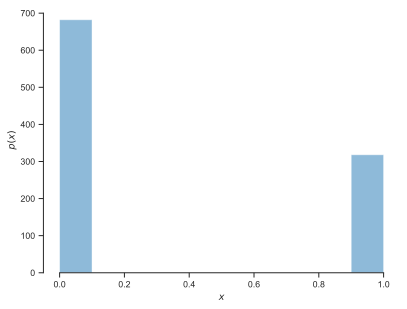

In [5]:
N = 1000
X = np.array(
    [sample_bernoulli(0.3) for _ in range(N)]
)
fig, ax = plt.subplots()
ax.hist(X, alpha=0.5)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$p(x)$")
sns.despine(trim=True);

Ok, it looks fine. About $\theta N$ samples went to 1 and $(1-\theta)N$ samples went to 0.

Of course, we have already seen this implemented in scipy.stats.
Here is a quick reminder of that code.

In [6]:
import scipy.stats as st
X = st.bernoulli(0.3)
X.rvs(size=10)

array([1, 1, 0, 1, 0, 0, 0, 0, 0, 0])

(categorical-sampling)=
## Sampling the $K$-label Categorical

Consider a generic discrete random variable $X$ taking $K$ different values.
You may assume that these values are integers $\{0, 1,2,\dots,K-1\}$ (they are just the labels of the discrete objects anyway).

The probability mass function of $X$ is:

$$
p(X=k) = p_k,
$$

where, of course, we must have:

$$
p_k \ge 0,
$$

and

$$
\sum_{k=0}^{K-1} p_k = 1.
$$

In any case, here is how you sample from such a distribution:

+ Draw a uniform sample $u$.
+ Find the index $j\in\{0,1,\dots,K-1\}$ such that:

$$
\sum_{k=0}^{j-1}p_k \le u < \sum_{k=0}^jp_k.
$$

+ Then, your sample is $j$.

```{admonition} Why does this work?
:class: dropdown

The probability that $u$ falls in the interval $[\sum_{k=0}^{j-1}p_k, \sum_{k=0}^jp_k)$ is:

$$
\sum_{k=0}^jp_k - \sum_{k=0}^{j-1}p_k = p_j.
$$

So, it is exactly the probability that $X=j$.

```

Let's code it:

In [7]:
def sample_categorical(p):
    """Sample from a discrete probability density.
    
    Arguments:
        p -- An array specifying the probability of each possible state.
             The number of states ``m=len(p)``.    
    """
    K = len(p)
    u = np.random.rand()
    c = 0.
    for j in range(K):
        c += p[j]
        if u <= c:
            return j

Let's test it with a four-state discrete random variable with probabilities:

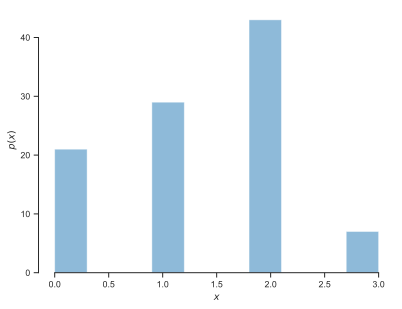

In [8]:
p = [0.2, 0.3, 0.4, 0.1]

N = 100
X = np.array(
    [sample_categorical(p) for _ in range(N)]
)

fig, ax = plt.subplots()
ax.hist(X, alpha=0.5)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$p(x)$")
sns.despine(trim=True);

Of course, ``scipy.stats`` already implements this functionality. Let's compare.

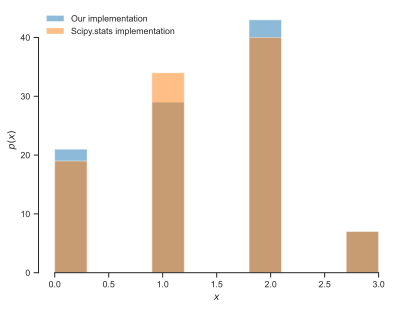

In [9]:
K = len(p)
X_st = st.rv_discrete(values=(np.arange(K), p))
x_st_samples = X_st.rvs(size=N)

# Let's compare the two histograms
fig, ax = plt.subplots()
ax.hist(X, alpha=0.5, label="Our implementation")
ax.hist(x_st_samples, alpha=0.5, label="Scipy.stats implementation")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$p(x)$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

## Questions

+ It looks like there is a lot of variability every time you run the results. You need to go back to the code and increase the number of samples $N$ until the results stop changing. Then you should be able to observe that our code does exactly the same thing as ``scipy.stats.rv_discrete``.